# Program Description: Machine Learning Modeling (MLP Regression - Module 10)

## Overview:
This module is responsible for building a multi-layer perceptron (MLP) regression model, training it on the provided dataset, and saving the best model after training. The input dataset (feature and label files) is loaded from the output of **Module 9** (where the dataset has been normalized).

## Key Steps:

1. **Dataset Loading**:
   - The module reads the **normalized dataset** (train and validation sets) generated in **Module 9**.
   - The dataset includes both **features** and **labels** required for training the model.

2. **Model Construction**:
   - An MLP regression model is built using the loaded dataset.
   - The model is configured and optimized for regression tasks.

3. **Training and Evaluation**:
   - The model is trained using the provided **training dataset**.
   - The performance of the model is evaluated using the **validation dataset**.
   - Hyperparameter tuning may be applied to improve the model's accuracy.

4. **Model Saving and Prediction**:
   - After training, the **best model** (based on validation performance) is saved.
   - The trained model is used to make predictions on the test set or additional unseen data.

## Output:
- The best trained model is saved in the `datasets-ml` folder under the current path. The saved model is named as follows:
  - `MLPmodel--{current_time}`, where `{current_time}` is the timestamp of the training session.

## Note:
- This module is parallel to other network models, meaning it can be used with other models or in conjunction with other training pipelines.
- The input data is provided as the output of **Module 9** (dataset normalization).


contacts：zhaohf@ihep.ac.cn

#  Import libraries

In [1]:
import sys
import os
import numpy as np
import matplotlib.pyplot as plt
import joblib
import logging
from datetime import datetime
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from tensorflow.keras import regularizers
import keras.callbacks
from tensorflow.keras.utils import plot_model
from IPython.display import Image, display

2025-01-15 19:03:35.224537: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


#  Version Information

In [2]:
def get_python_version():
    return sys.version
def get_package_version(package_name):
    try:
        module = __import__(package_name)
        version = getattr(module, '__version__', None)
        if version:
            return version
        else:
            return pkg_resources.get_distribution(package_name).version
    except (ImportError, AttributeError, pkg_resources.DistributionNotFound):
        return "Version info not found"

packages = ['tensorflow', 'numpy', 'joblib', 'matplotlib','keras']
for package in packages:
    print(f"{package}: {get_package_version(package)}")
print(f"Python: {get_python_version()}")

tensorflow: 2.9.1
numpy: 1.23.5
joblib: 1.4.0
matplotlib: 3.7.5
keras: 2.9.0
Python: 3.8.15 | packaged by conda-forge | (default, Nov 22 2022, 08:46:39) 
[GCC 10.4.0]


# Parameter Settings

## Input File Path:
- `dir_data`: Specifies the directory where the processed dataset (after preprocessing in Module 9) is located.
- Example: `'0926-datasets/datasets(JmolNN)-pre-xmu-cn'`
- The dataset includes **training**, **validation**, and **test** (features and labels), loaded from this directory.

## Output File Path:
- `dir_output`: The directory where the trained MLP model will be saved.
- The trained model is saved under the `ml-cn-xmu-(JmolNN)` folder, with a timestamp added to the model file name.
- Example: `'0926-datasets-ml/ml-cn-xmu-(JmolNN)'`
- The final model is saved with a filename that includes a timestamp for version tracking, e.g., `MLPmodel-20230101_1500`.

## Logging:
- `log_file_path`: The path where the training log file (`training_log.txt`) will be stored.
- This log file contains details about the dataset sizes, model training progress, and other relevant information.

## Model Hyperparameters (Structural Parameters):
The following parameters can be customized within the Multi-Layer Percet in the code yet:

- **Hidden Layers**: The number of hidden layers and their neuron sizes in the MLP.
  - Example: `[64, 32]` (two hidden layers with 64 and 32 neurons).
  
- **Activation Function**: The activation function used for the layers in the network.
  - Options: `'relu'`, `'tanh'`, `'sigmoid'`, etc.
  - Default: `'relu'`.
  
- **Learning Rate**: The learning rate for the optimization process.
  - Example: `0.001`.
  
- **Epochs**: Number of epochs to train the model.
  - Example: `50`.

- **Optimizer**: The optimization algorithm to be used.
  - Options: `'adam'`, `'sgd'`, etc.
  - Default: `'adam'`.
  
- **Loss Function**: The loss function used to optimize the model.
  - Example: `'mean_squared_error'` (commonly used for regression).
  
- **Batch Size**: The batch size for training the model.
  - Example: `32`.

In [3]:
# Set input file path
dir_data = '0926-datasets/datasets(JmolNN)-pre-xmu-cn'
# Set output file save path
output_path = '0926-datasets-ml/ml-cn-xmu-(JmolNN)'
current_time = datetime.now().strftime("%Y%m%d_%H%M")
# Output save file name and add timestamp
dir_output=os.path.join(output_path,f'MLPmodel-{current_time}')
# Check if the input path exists
if os.path.exists(dir_data):
    print(f"File '{dir_data}' exists.")
else:
    raise FileNotFoundError(f"File '{dir_data}' does not exist.")
os.makedirs(dir_output, exist_ok=True)
os.makedirs(dir_output, exist_ok=True)
# Load training, validation, and test datasets
file_train_feature = os.path.join(dir_data, 'xmu_train_JmolNN.txt')
file_train_label = os.path.join(dir_data, 'label_cn_train_JmolNN.txt')
file_valid_feature = os.path.join(dir_data, 'xmu_valid_JmolNN.txt')
file_valid_label = os.path.join(dir_data, 'label_cn_valid_JmolNN.txt')
file_test_feature = os.path.join(dir_data, 'xmu_test_JmolNN.txt')
file_test_label = os.path.join(dir_data, 'label_cn_test_JmolNN.txt')
log_file_path = os.path.join(dir_output, 'training_log.txt')
logging.basicConfig(level=logging.INFO, format='%(message)s', handlers=[logging.FileHandler(log_file_path), logging.StreamHandler()])
# Read data
X_train = np.loadtxt(file_train_feature)
y_train = np.loadtxt(file_train_label, dtype=float)
X_valid = np.loadtxt(file_valid_feature)
y_valid = np.loadtxt(file_valid_label, dtype=float)
X_test = np.loadtxt(file_test_feature)
y_test = np.loadtxt(file_test_label, dtype=float)
# Prepare messages for dataset sizes
train_size_message = f"Training set size: X_train: {X_train.shape}, y_train: {y_train.shape}"
valid_size_message = f"Validation set size: X_valid: {X_valid.shape}, y_valid: {y_valid.shape}"
test_size_message = f"Test set size: X_test: {X_test.shape}, y_test: {y_test.shape}"
print(train_size_message)
print(valid_size_message)
print(test_size_message)
# Log dataset sizes
logging.info(train_size_message)
logging.info(valid_size_message)
logging.info(test_size_message)

File '0926-datasets/datasets(JmolNN)-pre-xmu-cn' exists.


Training set size: X_train: (3455, 1000), y_train: (3455,)
Validation set size: X_valid: (987, 1000), y_valid: (987,)
Test set size: X_test: (495, 1000), y_test: (495,)


Training set size: X_train: (3455, 1000), y_train: (3455,)
Validation set size: X_valid: (987, 1000), y_valid: (987,)
Test set size: X_test: (495, 1000), y_test: (495,)


## Build a MLP regression model and save the best model results

In [4]:
# Standardize data
#scaler = StandardScaler()
#X_train = scaler.fit_transform(X_train)
#X_valid = scaler.transform(X_valid)
#X_test = scaler.transform(X_test)
#scaler_path = os.path.join(dir_output, 'scaler.pkl')
#joblib.dump(scaler, scaler_path)
#print(f"Scaler saved to: {scaler_path}")
# Build the mlp model
#model = Sequential()
#model.add(Dense(400, input_dim=X_train.shape[1], activation='relu'))  # Input layer and first hidden layer
#model.add(Dense(200, activation='relu'))
#model.add(Dense(100, activation='relu'))  # Second hidden layer
#model.add(Dense(1))  # Output layer with linear activation function (default)
model = Sequential()
model.add(Dense(512, input_dim=X_train.shape[1], activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dropout(0.2))  # Add Dropout layer
model.add(Dense(32, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
#model.add(Dense(16, activation='relu', kernel_regularizer=regularizers.l2(0.0001)))
model.add(Dense(1))
optimizer = Adam(learning_rate=0.001)
#model.compile(optimizer=optimizer, loss='mean_squared_error', metrics=['mean_squared_error'])
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mean_squared_error'])
# Set model save path
model_file = os.path.join(dir_output, 'best_model.h5')
# Set callbacks to save the model with the best performance on the validation set and to log training process
checkpoint = ModelCheckpoint(model_file, monitor='val_mean_squared_error', verbose=1, save_best_only=True, mode='min')
# Custom callback class to log training process
class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        log_message = (f"Epoch {epoch + 1}, "
                       f"Loss: {logs['loss']:.4f}, "
                       f"MSE: {logs['mean_squared_error']:.4f}, "
                       f"Val_Loss: {logs['val_loss']:.4f}, "
                       f"Val_MSE: {logs['val_mean_squared_error']:.4f}")
        logging.info(log_message)
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), epochs=100, batch_size=32, callbacks=[checkpoint, CustomCallback()])


Epoch 1/100


2025-01-15 19:03:38.294322: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


 99/108 [==========================>...] - ETA: 0s - loss: 4.3365 - mean_squared_error: 4.2072
Epoch 1: val_mean_squared_error improved from inf to 2.10532, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 1, Loss: 4.1442, MSE: 4.0151, Val_Loss: 2.2330, Val_MSE: 2.1053


108/108 [==============================] - 1s 8ms/step - loss: 4.1442 - mean_squared_error: 4.0151 - val_loss: 2.2330 - val_mean_squared_error: 2.1053
Epoch 2/100
107/108 [============================>.] - ETA: 0s - loss: 1.7065 - mean_squared_error: 1.5791
Epoch 2: val_mean_squared_error improved from 2.10532 to 1.64227, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 2, Loss: 1.7062, MSE: 1.5789, Val_Loss: 1.7693, Val_MSE: 1.6423


108/108 [==============================] - 1s 7ms/step - loss: 1.7062 - mean_squared_error: 1.5789 - val_loss: 1.7693 - val_mean_squared_error: 1.6423
Epoch 3/100
108/108 [==============================] - ETA: 0s - loss: 1.5929 - mean_squared_error: 1.4660
Epoch 3: val_mean_squared_error improved from 1.64227 to 1.17554, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 3, Loss: 1.5929, MSE: 1.4660, Val_Loss: 1.3024, Val_MSE: 1.1755


108/108 [==============================] - 1s 7ms/step - loss: 1.5929 - mean_squared_error: 1.4660 - val_loss: 1.3024 - val_mean_squared_error: 1.1755
Epoch 4/100
 98/108 [==========================>...] - ETA: 0s - loss: 1.2062 - mean_squared_error: 1.0796
Epoch 4: val_mean_squared_error did not improve from 1.17554


Epoch 4, Loss: 1.2097, MSE: 1.0831, Val_Loss: 1.4684, Val_MSE: 1.3420


108/108 [==============================] - 1s 6ms/step - loss: 1.2097 - mean_squared_error: 1.0831 - val_loss: 1.4684 - val_mean_squared_error: 1.3420
Epoch 5/100
 99/108 [==========================>...] - ETA: 0s - loss: 1.0782 - mean_squared_error: 0.9520
Epoch 5: val_mean_squared_error did not improve from 1.17554


Epoch 5, Loss: 1.0695, MSE: 0.9432, Val_Loss: 1.3653, Val_MSE: 1.2392


108/108 [==============================] - 1s 6ms/step - loss: 1.0695 - mean_squared_error: 0.9432 - val_loss: 1.3653 - val_mean_squared_error: 1.2392
Epoch 6/100
100/108 [==========================>...] - ETA: 0s - loss: 1.0096 - mean_squared_error: 0.8837
Epoch 6: val_mean_squared_error improved from 1.17554 to 0.81685, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 6, Loss: 0.9872, MSE: 0.8613, Val_Loss: 0.9426, Val_MSE: 0.8168


108/108 [==============================] - 1s 6ms/step - loss: 0.9872 - mean_squared_error: 0.8613 - val_loss: 0.9426 - val_mean_squared_error: 0.8168
Epoch 7/100
 98/108 [==========================>...] - ETA: 0s - loss: 1.0254 - mean_squared_error: 0.8999
Epoch 7: val_mean_squared_error did not improve from 0.81685


Epoch 7, Loss: 1.0089, MSE: 0.8834, Val_Loss: 1.1518, Val_MSE: 1.0265


108/108 [==============================] - 1s 6ms/step - loss: 1.0089 - mean_squared_error: 0.8834 - val_loss: 1.1518 - val_mean_squared_error: 1.0265
Epoch 8/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.9500 - mean_squared_error: 0.8249
Epoch 8: val_mean_squared_error did not improve from 0.81685


Epoch 8, Loss: 0.9586, MSE: 0.8334, Val_Loss: 1.6466, Val_MSE: 1.5217


108/108 [==============================] - 1s 6ms/step - loss: 0.9586 - mean_squared_error: 0.8334 - val_loss: 1.6466 - val_mean_squared_error: 1.5217
Epoch 9/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.9627 - mean_squared_error: 0.8378
Epoch 9: val_mean_squared_error did not improve from 0.81685


Epoch 9, Loss: 0.9662, MSE: 0.8414, Val_Loss: 0.9680, Val_MSE: 0.8433


108/108 [==============================] - 1s 6ms/step - loss: 0.9662 - mean_squared_error: 0.8414 - val_loss: 0.9680 - val_mean_squared_error: 0.8433
Epoch 10/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.8038 - mean_squared_error: 0.6794
Epoch 10: val_mean_squared_error did not improve from 0.81685


Epoch 10, Loss: 0.8132, MSE: 0.6887, Val_Loss: 1.1115, Val_MSE: 0.9873


108/108 [==============================] - 1s 6ms/step - loss: 0.8132 - mean_squared_error: 0.6887 - val_loss: 1.1115 - val_mean_squared_error: 0.9873
Epoch 11/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.7844 - mean_squared_error: 0.6605
Epoch 11: val_mean_squared_error did not improve from 0.81685


Epoch 11, Loss: 0.8161, MSE: 0.6922, Val_Loss: 1.1362, Val_MSE: 1.0125


108/108 [==============================] - 1s 6ms/step - loss: 0.8161 - mean_squared_error: 0.6922 - val_loss: 1.1362 - val_mean_squared_error: 1.0125
Epoch 12/100
100/108 [==========================>...] - ETA: 0s - loss: 0.7668 - mean_squared_error: 0.6433
Epoch 12: val_mean_squared_error improved from 0.81685 to 0.81012, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 12, Loss: 0.7645, MSE: 0.6410, Val_Loss: 0.9334, Val_MSE: 0.8101


108/108 [==============================] - 1s 7ms/step - loss: 0.7645 - mean_squared_error: 0.6410 - val_loss: 0.9334 - val_mean_squared_error: 0.8101
Epoch 13/100
106/108 [============================>.] - ETA: 0s - loss: 0.7856 - mean_squared_error: 0.6626
Epoch 13: val_mean_squared_error improved from 0.81012 to 0.62941, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 13, Loss: 0.7850, MSE: 0.6620, Val_Loss: 0.7521, Val_MSE: 0.6294


108/108 [==============================] - 1s 7ms/step - loss: 0.7850 - mean_squared_error: 0.6620 - val_loss: 0.7521 - val_mean_squared_error: 0.6294
Epoch 14/100
100/108 [==========================>...] - ETA: 0s - loss: 0.7733 - mean_squared_error: 0.6508
Epoch 14: val_mean_squared_error did not improve from 0.62941


Epoch 14, Loss: 0.7686, MSE: 0.6461, Val_Loss: 0.8407, Val_MSE: 0.7185


108/108 [==============================] - 1s 6ms/step - loss: 0.7686 - mean_squared_error: 0.6461 - val_loss: 0.8407 - val_mean_squared_error: 0.7185
Epoch 15/100
108/108 [==============================] - ETA: 0s - loss: 0.7942 - mean_squared_error: 0.6720
Epoch 15: val_mean_squared_error did not improve from 0.62941


Epoch 15, Loss: 0.7942, MSE: 0.6720, Val_Loss: 0.7917, Val_MSE: 0.6698


108/108 [==============================] - 1s 6ms/step - loss: 0.7942 - mean_squared_error: 0.6720 - val_loss: 0.7917 - val_mean_squared_error: 0.6698
Epoch 16/100
100/108 [==========================>...] - ETA: 0s - loss: 0.6988 - mean_squared_error: 0.5772
Epoch 16: val_mean_squared_error improved from 0.62941 to 0.60565, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 16, Loss: 0.7008, MSE: 0.5792, Val_Loss: 0.7269, Val_MSE: 0.6056


108/108 [==============================] - 1s 7ms/step - loss: 0.7008 - mean_squared_error: 0.5792 - val_loss: 0.7269 - val_mean_squared_error: 0.6056
Epoch 17/100
100/108 [==========================>...] - ETA: 0s - loss: 0.6271 - mean_squared_error: 0.5061
Epoch 17: val_mean_squared_error did not improve from 0.60565


Epoch 17, Loss: 0.6252, MSE: 0.5042, Val_Loss: 0.7738, Val_MSE: 0.6532


108/108 [==============================] - 1s 6ms/step - loss: 0.6252 - mean_squared_error: 0.5042 - val_loss: 0.7738 - val_mean_squared_error: 0.6532
Epoch 18/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.6812 - mean_squared_error: 0.5610
Epoch 18: val_mean_squared_error improved from 0.60565 to 0.54001, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 18, Loss: 0.6725, MSE: 0.5523, Val_Loss: 0.6599, Val_MSE: 0.5400


108/108 [==============================] - 1s 7ms/step - loss: 0.6725 - mean_squared_error: 0.5523 - val_loss: 0.6599 - val_mean_squared_error: 0.5400
Epoch 19/100
100/108 [==========================>...] - ETA: 0s - loss: 0.6936 - mean_squared_error: 0.5740
Epoch 19: val_mean_squared_error did not improve from 0.54001


Epoch 19, Loss: 0.6805, MSE: 0.5609, Val_Loss: 0.7440, Val_MSE: 0.6247


108/108 [==============================] - 1s 6ms/step - loss: 0.6805 - mean_squared_error: 0.5609 - val_loss: 0.7440 - val_mean_squared_error: 0.6247
Epoch 20/100
106/108 [============================>.] - ETA: 0s - loss: 0.6766 - mean_squared_error: 0.5576
Epoch 20: val_mean_squared_error did not improve from 0.54001


Epoch 20, Loss: 0.6783, MSE: 0.5594, Val_Loss: 1.1251, Val_MSE: 1.0064


108/108 [==============================] - 1s 6ms/step - loss: 0.6783 - mean_squared_error: 0.5594 - val_loss: 1.1251 - val_mean_squared_error: 1.0064
Epoch 21/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5913 - mean_squared_error: 0.4729
Epoch 21: val_mean_squared_error improved from 0.54001 to 0.49805, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 21, Loss: 0.5927, MSE: 0.4743, Val_Loss: 0.6160, Val_MSE: 0.4980


108/108 [==============================] - 1s 7ms/step - loss: 0.5927 - mean_squared_error: 0.4743 - val_loss: 0.6160 - val_mean_squared_error: 0.4980
Epoch 22/100
 98/108 [==========================>...] - ETA: 0s - loss: 0.6766 - mean_squared_error: 0.5590
Epoch 22: val_mean_squared_error did not improve from 0.49805


Epoch 22, Loss: 0.6805, MSE: 0.5629, Val_Loss: 0.9522, Val_MSE: 0.8349


108/108 [==============================] - 1s 6ms/step - loss: 0.6805 - mean_squared_error: 0.5629 - val_loss: 0.9522 - val_mean_squared_error: 0.8349
Epoch 23/100
106/108 [============================>.] - ETA: 0s - loss: 0.6592 - mean_squared_error: 0.5422
Epoch 23: val_mean_squared_error did not improve from 0.49805


Epoch 23, Loss: 0.6616, MSE: 0.5446, Val_Loss: 0.6317, Val_MSE: 0.5151


108/108 [==============================] - 1s 6ms/step - loss: 0.6616 - mean_squared_error: 0.5446 - val_loss: 0.6317 - val_mean_squared_error: 0.5151
Epoch 24/100
 98/108 [==========================>...] - ETA: 0s - loss: 0.7644 - mean_squared_error: 0.6481
Epoch 24: val_mean_squared_error did not improve from 0.49805


Epoch 24, Loss: 0.7656, MSE: 0.6493, Val_Loss: 0.6796, Val_MSE: 0.5635


108/108 [==============================] - 1s 6ms/step - loss: 0.7656 - mean_squared_error: 0.6493 - val_loss: 0.6796 - val_mean_squared_error: 0.5635
Epoch 25/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5755 - mean_squared_error: 0.4598
Epoch 25: val_mean_squared_error did not improve from 0.49805


Epoch 25, Loss: 0.5721, MSE: 0.4564, Val_Loss: 0.6461, Val_MSE: 0.5308


108/108 [==============================] - 1s 6ms/step - loss: 0.5721 - mean_squared_error: 0.4564 - val_loss: 0.6461 - val_mean_squared_error: 0.5308
Epoch 26/100
103/108 [===========================>..] - ETA: 0s - loss: 0.5919 - mean_squared_error: 0.4771
Epoch 26: val_mean_squared_error did not improve from 0.49805


Epoch 26, Loss: 0.5886, MSE: 0.4738, Val_Loss: 0.6965, Val_MSE: 0.5822


108/108 [==============================] - 1s 6ms/step - loss: 0.5886 - mean_squared_error: 0.4738 - val_loss: 0.6965 - val_mean_squared_error: 0.5822
Epoch 27/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.6171 - mean_squared_error: 0.5032
Epoch 27: val_mean_squared_error did not improve from 0.49805


Epoch 27, Loss: 0.6196, MSE: 0.5058, Val_Loss: 0.7750, Val_MSE: 0.6615


108/108 [==============================] - 1s 6ms/step - loss: 0.6196 - mean_squared_error: 0.5058 - val_loss: 0.7750 - val_mean_squared_error: 0.6615
Epoch 28/100
101/108 [===========================>..] - ETA: 0s - loss: 0.5482 - mean_squared_error: 0.4352
Epoch 28: val_mean_squared_error did not improve from 0.49805


Epoch 28, Loss: 0.5496, MSE: 0.4366, Val_Loss: 0.6465, Val_MSE: 0.5339


108/108 [==============================] - 1s 6ms/step - loss: 0.5496 - mean_squared_error: 0.4366 - val_loss: 0.6465 - val_mean_squared_error: 0.5339
Epoch 29/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5484 - mean_squared_error: 0.4363
Epoch 29: val_mean_squared_error did not improve from 0.49805


Epoch 29, Loss: 0.5580, MSE: 0.4459, Val_Loss: 0.6632, Val_MSE: 0.5517


108/108 [==============================] - 1s 6ms/step - loss: 0.5580 - mean_squared_error: 0.4459 - val_loss: 0.6632 - val_mean_squared_error: 0.5517
Epoch 30/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5219 - mean_squared_error: 0.4108
Epoch 30: val_mean_squared_error did not improve from 0.49805


Epoch 30, Loss: 0.5326, MSE: 0.4216, Val_Loss: 0.7094, Val_MSE: 0.5988


108/108 [==============================] - 1s 6ms/step - loss: 0.5326 - mean_squared_error: 0.4216 - val_loss: 0.7094 - val_mean_squared_error: 0.5988
Epoch 31/100
104/108 [===========================>..] - ETA: 0s - loss: 0.5527 - mean_squared_error: 0.4425
Epoch 31: val_mean_squared_error did not improve from 0.49805


Epoch 31, Loss: 0.5494, MSE: 0.4393, Val_Loss: 0.8401, Val_MSE: 0.7306


108/108 [==============================] - 1s 6ms/step - loss: 0.5494 - mean_squared_error: 0.4393 - val_loss: 0.8401 - val_mean_squared_error: 0.7306
Epoch 32/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5082 - mean_squared_error: 0.3991
Epoch 32: val_mean_squared_error did not improve from 0.49805


Epoch 32, Loss: 0.5110, MSE: 0.4020, Val_Loss: 0.6318, Val_MSE: 0.5234


108/108 [==============================] - 1s 6ms/step - loss: 0.5110 - mean_squared_error: 0.4020 - val_loss: 0.6318 - val_mean_squared_error: 0.5234
Epoch 33/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5696 - mean_squared_error: 0.4616
Epoch 33: val_mean_squared_error did not improve from 0.49805


Epoch 33, Loss: 0.5580, MSE: 0.4500, Val_Loss: 0.6088, Val_MSE: 0.5013


108/108 [==============================] - 1s 6ms/step - loss: 0.5580 - mean_squared_error: 0.4500 - val_loss: 0.6088 - val_mean_squared_error: 0.5013
Epoch 34/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5286 - mean_squared_error: 0.4216
Epoch 34: val_mean_squared_error did not improve from 0.49805


Epoch 34, Loss: 0.5452, MSE: 0.4382, Val_Loss: 0.7738, Val_MSE: 0.6674


108/108 [==============================] - 1s 6ms/step - loss: 0.5452 - mean_squared_error: 0.4382 - val_loss: 0.7738 - val_mean_squared_error: 0.6674
Epoch 35/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5460 - mean_squared_error: 0.4400
Epoch 35: val_mean_squared_error did not improve from 0.49805


Epoch 35, Loss: 0.5461, MSE: 0.4402, Val_Loss: 0.9201, Val_MSE: 0.8146


108/108 [==============================] - 1s 6ms/step - loss: 0.5461 - mean_squared_error: 0.4402 - val_loss: 0.9201 - val_mean_squared_error: 0.8146
Epoch 36/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5344 - mean_squared_error: 0.4294
Epoch 36: val_mean_squared_error did not improve from 0.49805


Epoch 36, Loss: 0.5377, MSE: 0.4328, Val_Loss: 0.7214, Val_MSE: 0.6170


108/108 [==============================] - 1s 6ms/step - loss: 0.5377 - mean_squared_error: 0.4328 - val_loss: 0.7214 - val_mean_squared_error: 0.6170
Epoch 37/100
100/108 [==========================>...] - ETA: 0s - loss: 0.6215 - mean_squared_error: 0.5175
Epoch 37: val_mean_squared_error did not improve from 0.49805


Epoch 37, Loss: 0.6135, MSE: 0.5096, Val_Loss: 0.8161, Val_MSE: 0.7123


108/108 [==============================] - 1s 6ms/step - loss: 0.6135 - mean_squared_error: 0.5096 - val_loss: 0.8161 - val_mean_squared_error: 0.7123
Epoch 38/100
102/108 [===========================>..] - ETA: 0s - loss: 0.5360 - mean_squared_error: 0.4329
Epoch 38: val_mean_squared_error did not improve from 0.49805


Epoch 38, Loss: 0.5366, MSE: 0.4334, Val_Loss: 0.6129, Val_MSE: 0.5103


108/108 [==============================] - 1s 6ms/step - loss: 0.5366 - mean_squared_error: 0.4334 - val_loss: 0.6129 - val_mean_squared_error: 0.5103
Epoch 39/100
 98/108 [==========================>...] - ETA: 0s - loss: 0.5228 - mean_squared_error: 0.4207
Epoch 39: val_mean_squared_error improved from 0.49805 to 0.47528, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 39, Loss: 0.5136, MSE: 0.4116, Val_Loss: 0.5768, Val_MSE: 0.4753


108/108 [==============================] - 1s 7ms/step - loss: 0.5136 - mean_squared_error: 0.4116 - val_loss: 0.5768 - val_mean_squared_error: 0.4753
Epoch 40/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.5486 - mean_squared_error: 0.4475
Epoch 40: val_mean_squared_error did not improve from 0.47528


Epoch 40, Loss: 0.5429, MSE: 0.4419, Val_Loss: 0.6065, Val_MSE: 0.5060


108/108 [==============================] - 1s 6ms/step - loss: 0.5429 - mean_squared_error: 0.4419 - val_loss: 0.6065 - val_mean_squared_error: 0.5060
Epoch 41/100
104/108 [===========================>..] - ETA: 0s - loss: 0.4871 - mean_squared_error: 0.3872
Epoch 41: val_mean_squared_error improved from 0.47528 to 0.39760, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 41, Loss: 0.4910, MSE: 0.3911, Val_Loss: 0.4968, Val_MSE: 0.3976


108/108 [==============================] - 1s 7ms/step - loss: 0.4910 - mean_squared_error: 0.3911 - val_loss: 0.4968 - val_mean_squared_error: 0.3976
Epoch 42/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5308 - mean_squared_error: 0.4320
Epoch 42: val_mean_squared_error did not improve from 0.39760


Epoch 42, Loss: 0.5349, MSE: 0.4361, Val_Loss: 0.5710, Val_MSE: 0.4726


108/108 [==============================] - 1s 6ms/step - loss: 0.5349 - mean_squared_error: 0.4361 - val_loss: 0.5710 - val_mean_squared_error: 0.4726
Epoch 43/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5249 - mean_squared_error: 0.4271
Epoch 43: val_mean_squared_error did not improve from 0.39760


Epoch 43, Loss: 0.5277, MSE: 0.4300, Val_Loss: 0.8667, Val_MSE: 0.7695


108/108 [==============================] - 1s 6ms/step - loss: 0.5277 - mean_squared_error: 0.4300 - val_loss: 0.8667 - val_mean_squared_error: 0.7695
Epoch 44/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5069 - mean_squared_error: 0.4102
Epoch 44: val_mean_squared_error did not improve from 0.39760


Epoch 44, Loss: 0.5074, MSE: 0.4107, Val_Loss: 0.6467, Val_MSE: 0.5506


108/108 [==============================] - 1s 6ms/step - loss: 0.5074 - mean_squared_error: 0.4107 - val_loss: 0.6467 - val_mean_squared_error: 0.5506
Epoch 45/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5126 - mean_squared_error: 0.4170
Epoch 45: val_mean_squared_error did not improve from 0.39760


Epoch 45, Loss: 0.5170, MSE: 0.4214, Val_Loss: 0.5326, Val_MSE: 0.4376


108/108 [==============================] - 1s 6ms/step - loss: 0.5170 - mean_squared_error: 0.4214 - val_loss: 0.5326 - val_mean_squared_error: 0.4376
Epoch 46/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5064 - mean_squared_error: 0.4120
Epoch 46: val_mean_squared_error did not improve from 0.39760


Epoch 46, Loss: 0.5002, MSE: 0.4058, Val_Loss: 0.5436, Val_MSE: 0.4497


108/108 [==============================] - 1s 6ms/step - loss: 0.5002 - mean_squared_error: 0.4058 - val_loss: 0.5436 - val_mean_squared_error: 0.4497
Epoch 47/100
104/108 [===========================>..] - ETA: 0s - loss: 0.4946 - mean_squared_error: 0.4013
Epoch 47: val_mean_squared_error did not improve from 0.39760


Epoch 47, Loss: 0.4974, MSE: 0.4041, Val_Loss: 0.5654, Val_MSE: 0.4727


108/108 [==============================] - 1s 6ms/step - loss: 0.4974 - mean_squared_error: 0.4041 - val_loss: 0.5654 - val_mean_squared_error: 0.4727
Epoch 48/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.4982 - mean_squared_error: 0.4060
Epoch 48: val_mean_squared_error did not improve from 0.39760


Epoch 48, Loss: 0.4915, MSE: 0.3993, Val_Loss: 0.6484, Val_MSE: 0.5567


108/108 [==============================] - 1s 6ms/step - loss: 0.4915 - mean_squared_error: 0.3993 - val_loss: 0.6484 - val_mean_squared_error: 0.5567
Epoch 49/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4705 - mean_squared_error: 0.3794
Epoch 49: val_mean_squared_error did not improve from 0.39760


Epoch 49, Loss: 0.4728, MSE: 0.3817, Val_Loss: 0.4966, Val_MSE: 0.4063


108/108 [==============================] - 1s 6ms/step - loss: 0.4728 - mean_squared_error: 0.3817 - val_loss: 0.4966 - val_mean_squared_error: 0.4063
Epoch 50/100
108/108 [==============================] - ETA: 0s - loss: 0.5275 - mean_squared_error: 0.4377
Epoch 50: val_mean_squared_error did not improve from 0.39760


Epoch 50, Loss: 0.5275, MSE: 0.4377, Val_Loss: 0.6337, Val_MSE: 0.5443


108/108 [==============================] - 1s 6ms/step - loss: 0.5275 - mean_squared_error: 0.4377 - val_loss: 0.6337 - val_mean_squared_error: 0.5443
Epoch 51/100
100/108 [==========================>...] - ETA: 0s - loss: 0.5172 - mean_squared_error: 0.4283
Epoch 51: val_mean_squared_error did not improve from 0.39760


Epoch 51, Loss: 0.5092, MSE: 0.4203, Val_Loss: 0.5271, Val_MSE: 0.4387


108/108 [==============================] - 1s 6ms/step - loss: 0.5092 - mean_squared_error: 0.4203 - val_loss: 0.5271 - val_mean_squared_error: 0.4387
Epoch 52/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4575 - mean_squared_error: 0.3697
Epoch 52: val_mean_squared_error did not improve from 0.39760


Epoch 52, Loss: 0.4591, MSE: 0.3714, Val_Loss: 0.4925, Val_MSE: 0.4053


108/108 [==============================] - 1s 6ms/step - loss: 0.4591 - mean_squared_error: 0.3714 - val_loss: 0.4925 - val_mean_squared_error: 0.4053
Epoch 53/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4741 - mean_squared_error: 0.3876
Epoch 53: val_mean_squared_error did not improve from 0.39760


Epoch 53, Loss: 0.4680, MSE: 0.3815, Val_Loss: 0.4909, Val_MSE: 0.4050


108/108 [==============================] - 1s 6ms/step - loss: 0.4680 - mean_squared_error: 0.3815 - val_loss: 0.4909 - val_mean_squared_error: 0.4050
Epoch 54/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4764 - mean_squared_error: 0.3911
Epoch 54: val_mean_squared_error did not improve from 0.39760


Epoch 54, Loss: 0.4785, MSE: 0.3932, Val_Loss: 0.5922, Val_MSE: 0.5073


108/108 [==============================] - 1s 6ms/step - loss: 0.4785 - mean_squared_error: 0.3932 - val_loss: 0.5922 - val_mean_squared_error: 0.5073
Epoch 55/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.4696 - mean_squared_error: 0.3852
Epoch 55: val_mean_squared_error did not improve from 0.39760


Epoch 55, Loss: 0.4654, MSE: 0.3811, Val_Loss: 0.7149, Val_MSE: 0.6312


108/108 [==============================] - 1s 6ms/step - loss: 0.4654 - mean_squared_error: 0.3811 - val_loss: 0.7149 - val_mean_squared_error: 0.6312
Epoch 56/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4643 - mean_squared_error: 0.3809
Epoch 56: val_mean_squared_error did not improve from 0.39760


Epoch 56, Loss: 0.4650, MSE: 0.3817, Val_Loss: 0.5538, Val_MSE: 0.4711


108/108 [==============================] - 1s 6ms/step - loss: 0.4650 - mean_squared_error: 0.3817 - val_loss: 0.5538 - val_mean_squared_error: 0.4711
Epoch 57/100
103/108 [===========================>..] - ETA: 0s - loss: 0.4507 - mean_squared_error: 0.3688
Epoch 57: val_mean_squared_error did not improve from 0.39760


Epoch 57, Loss: 0.4494, MSE: 0.3674, Val_Loss: 0.4837, Val_MSE: 0.4025


108/108 [==============================] - 1s 6ms/step - loss: 0.4494 - mean_squared_error: 0.3674 - val_loss: 0.4837 - val_mean_squared_error: 0.4025
Epoch 58/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4594 - mean_squared_error: 0.3786
Epoch 58: val_mean_squared_error did not improve from 0.39760


Epoch 58, Loss: 0.4594, MSE: 0.3787, Val_Loss: 0.6092, Val_MSE: 0.5291


108/108 [==============================] - 1s 6ms/step - loss: 0.4594 - mean_squared_error: 0.3787 - val_loss: 0.6092 - val_mean_squared_error: 0.5291
Epoch 59/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4226 - mean_squared_error: 0.3431
Epoch 59: val_mean_squared_error did not improve from 0.39760


Epoch 59, Loss: 0.4301, MSE: 0.3507, Val_Loss: 0.4826, Val_MSE: 0.4038


108/108 [==============================] - 1s 6ms/step - loss: 0.4301 - mean_squared_error: 0.3507 - val_loss: 0.4826 - val_mean_squared_error: 0.4038
Epoch 60/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4745 - mean_squared_error: 0.3960
Epoch 60: val_mean_squared_error did not improve from 0.39760


Epoch 60, Loss: 0.4779, MSE: 0.3995, Val_Loss: 0.5260, Val_MSE: 0.4481


108/108 [==============================] - 1s 6ms/step - loss: 0.4779 - mean_squared_error: 0.3995 - val_loss: 0.5260 - val_mean_squared_error: 0.4481
Epoch 61/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4404 - mean_squared_error: 0.3628
Epoch 61: val_mean_squared_error did not improve from 0.39760


Epoch 61, Loss: 0.4398, MSE: 0.3623, Val_Loss: 0.4821, Val_MSE: 0.4051


108/108 [==============================] - 1s 6ms/step - loss: 0.4398 - mean_squared_error: 0.3623 - val_loss: 0.4821 - val_mean_squared_error: 0.4051
Epoch 62/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4539 - mean_squared_error: 0.3775
Epoch 62: val_mean_squared_error did not improve from 0.39760


Epoch 62, Loss: 0.4540, MSE: 0.3776, Val_Loss: 0.5519, Val_MSE: 0.4762


108/108 [==============================] - 1s 6ms/step - loss: 0.4540 - mean_squared_error: 0.3776 - val_loss: 0.5519 - val_mean_squared_error: 0.4762
Epoch 63/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4405 - mean_squared_error: 0.3653
Epoch 63: val_mean_squared_error did not improve from 0.39760


Epoch 63, Loss: 0.4444, MSE: 0.3693, Val_Loss: 0.6632, Val_MSE: 0.5886


108/108 [==============================] - 1s 6ms/step - loss: 0.4444 - mean_squared_error: 0.3693 - val_loss: 0.6632 - val_mean_squared_error: 0.5886
Epoch 64/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4398 - mean_squared_error: 0.3657
Epoch 64: val_mean_squared_error improved from 0.39760 to 0.39586, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 64, Loss: 0.4424, MSE: 0.3684, Val_Loss: 0.4692, Val_MSE: 0.3959


108/108 [==============================] - 1s 7ms/step - loss: 0.4424 - mean_squared_error: 0.3684 - val_loss: 0.4692 - val_mean_squared_error: 0.3959
Epoch 65/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4475 - mean_squared_error: 0.3746
Epoch 65: val_mean_squared_error did not improve from 0.39586


Epoch 65, Loss: 0.4448, MSE: 0.3719, Val_Loss: 0.5028, Val_MSE: 0.4305


108/108 [==============================] - 1s 6ms/step - loss: 0.4448 - mean_squared_error: 0.3719 - val_loss: 0.5028 - val_mean_squared_error: 0.4305
Epoch 66/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4464 - mean_squared_error: 0.3744
Epoch 66: val_mean_squared_error did not improve from 0.39586


Epoch 66, Loss: 0.4438, MSE: 0.3719, Val_Loss: 0.5386, Val_MSE: 0.4673


108/108 [==============================] - 1s 6ms/step - loss: 0.4438 - mean_squared_error: 0.3719 - val_loss: 0.5386 - val_mean_squared_error: 0.4673
Epoch 67/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4383 - mean_squared_error: 0.3675
Epoch 67: val_mean_squared_error improved from 0.39586 to 0.35839, saving model to 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/best_model.h5


Epoch 67, Loss: 0.4384, MSE: 0.3677, Val_Loss: 0.4284, Val_MSE: 0.3584


108/108 [==============================] - 1s 7ms/step - loss: 0.4384 - mean_squared_error: 0.3677 - val_loss: 0.4284 - val_mean_squared_error: 0.3584
Epoch 68/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4119 - mean_squared_error: 0.3422
Epoch 68: val_mean_squared_error did not improve from 0.35839


Epoch 68, Loss: 0.4160, MSE: 0.3463, Val_Loss: 0.4373, Val_MSE: 0.3680


108/108 [==============================] - 1s 6ms/step - loss: 0.4160 - mean_squared_error: 0.3463 - val_loss: 0.4373 - val_mean_squared_error: 0.3680
Epoch 69/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4387 - mean_squared_error: 0.3699
Epoch 69: val_mean_squared_error did not improve from 0.35839


Epoch 69, Loss: 0.4396, MSE: 0.3708, Val_Loss: 0.4640, Val_MSE: 0.3957


108/108 [==============================] - 1s 6ms/step - loss: 0.4396 - mean_squared_error: 0.3708 - val_loss: 0.4640 - val_mean_squared_error: 0.3957
Epoch 70/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4668 - mean_squared_error: 0.3988
Epoch 70: val_mean_squared_error did not improve from 0.35839


Epoch 70, Loss: 0.4638, MSE: 0.3957, Val_Loss: 0.4667, Val_MSE: 0.3990


108/108 [==============================] - 1s 6ms/step - loss: 0.4638 - mean_squared_error: 0.3957 - val_loss: 0.4667 - val_mean_squared_error: 0.3990
Epoch 71/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4460 - mean_squared_error: 0.3787
Epoch 71: val_mean_squared_error did not improve from 0.35839


Epoch 71, Loss: 0.4463, MSE: 0.3790, Val_Loss: 0.5304, Val_MSE: 0.4636


108/108 [==============================] - 1s 6ms/step - loss: 0.4463 - mean_squared_error: 0.3790 - val_loss: 0.5304 - val_mean_squared_error: 0.4636
Epoch 72/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4631 - mean_squared_error: 0.3964
Epoch 72: val_mean_squared_error did not improve from 0.35839


Epoch 72, Loss: 0.4601, MSE: 0.3934, Val_Loss: 0.4635, Val_MSE: 0.3971


108/108 [==============================] - 1s 6ms/step - loss: 0.4601 - mean_squared_error: 0.3934 - val_loss: 0.4635 - val_mean_squared_error: 0.3971
Epoch 73/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4292 - mean_squared_error: 0.3633
Epoch 73: val_mean_squared_error did not improve from 0.35839


Epoch 73, Loss: 0.4271, MSE: 0.3612, Val_Loss: 0.4896, Val_MSE: 0.4240


108/108 [==============================] - 1s 6ms/step - loss: 0.4271 - mean_squared_error: 0.3612 - val_loss: 0.4896 - val_mean_squared_error: 0.4240
Epoch 74/100
 98/108 [==========================>...] - ETA: 0s - loss: 0.4171 - mean_squared_error: 0.3519
Epoch 74: val_mean_squared_error did not improve from 0.35839


Epoch 74, Loss: 0.4171, MSE: 0.3520, Val_Loss: 0.4812, Val_MSE: 0.4164


108/108 [==============================] - 1s 6ms/step - loss: 0.4171 - mean_squared_error: 0.3520 - val_loss: 0.4812 - val_mean_squared_error: 0.4164
Epoch 75/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.4208 - mean_squared_error: 0.3564
Epoch 75: val_mean_squared_error did not improve from 0.35839


Epoch 75, Loss: 0.4225, MSE: 0.3582, Val_Loss: 0.4432, Val_MSE: 0.3794


108/108 [==============================] - 1s 6ms/step - loss: 0.4225 - mean_squared_error: 0.3582 - val_loss: 0.4432 - val_mean_squared_error: 0.3794
Epoch 76/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.4035 - mean_squared_error: 0.3401
Epoch 76: val_mean_squared_error did not improve from 0.35839


Epoch 76, Loss: 0.4074, MSE: 0.3441, Val_Loss: 0.4611, Val_MSE: 0.3982


108/108 [==============================] - 1s 6ms/step - loss: 0.4074 - mean_squared_error: 0.3441 - val_loss: 0.4611 - val_mean_squared_error: 0.3982
Epoch 77/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4272 - mean_squared_error: 0.3646
Epoch 77: val_mean_squared_error did not improve from 0.35839


Epoch 77, Loss: 0.4250, MSE: 0.3624, Val_Loss: 0.4453, Val_MSE: 0.3833


108/108 [==============================] - 1s 6ms/step - loss: 0.4250 - mean_squared_error: 0.3624 - val_loss: 0.4453 - val_mean_squared_error: 0.3833
Epoch 78/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.4498 - mean_squared_error: 0.3880
Epoch 78: val_mean_squared_error did not improve from 0.35839


Epoch 78, Loss: 0.4362, MSE: 0.3744, Val_Loss: 0.4566, Val_MSE: 0.3952


108/108 [==============================] - 1s 6ms/step - loss: 0.4362 - mean_squared_error: 0.3744 - val_loss: 0.4566 - val_mean_squared_error: 0.3952
Epoch 79/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.4009 - mean_squared_error: 0.3400
Epoch 79: val_mean_squared_error did not improve from 0.35839


Epoch 79, Loss: 0.4064, MSE: 0.3455, Val_Loss: 0.4641, Val_MSE: 0.4038


108/108 [==============================] - 1s 6ms/step - loss: 0.4064 - mean_squared_error: 0.3455 - val_loss: 0.4641 - val_mean_squared_error: 0.4038
Epoch 80/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.4134 - mean_squared_error: 0.3533
Epoch 80: val_mean_squared_error did not improve from 0.35839


Epoch 80, Loss: 0.4158, MSE: 0.3558, Val_Loss: 0.4453, Val_MSE: 0.3854


108/108 [==============================] - 1s 6ms/step - loss: 0.4158 - mean_squared_error: 0.3558 - val_loss: 0.4453 - val_mean_squared_error: 0.3854
Epoch 81/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4022 - mean_squared_error: 0.3426
Epoch 81: val_mean_squared_error did not improve from 0.35839


Epoch 81, Loss: 0.4096, MSE: 0.3500, Val_Loss: 0.5638, Val_MSE: 0.5045


108/108 [==============================] - 1s 6ms/step - loss: 0.4096 - mean_squared_error: 0.3500 - val_loss: 0.5638 - val_mean_squared_error: 0.5045
Epoch 82/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4412 - mean_squared_error: 0.3821
Epoch 82: val_mean_squared_error did not improve from 0.35839


Epoch 82, Loss: 0.4375, MSE: 0.3785, Val_Loss: 0.5469, Val_MSE: 0.4882


108/108 [==============================] - 1s 6ms/step - loss: 0.4375 - mean_squared_error: 0.3785 - val_loss: 0.5469 - val_mean_squared_error: 0.4882
Epoch 83/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3994 - mean_squared_error: 0.3412
Epoch 83: val_mean_squared_error did not improve from 0.35839


Epoch 83, Loss: 0.4029, MSE: 0.3448, Val_Loss: 0.4739, Val_MSE: 0.4162


108/108 [==============================] - 1s 6ms/step - loss: 0.4029 - mean_squared_error: 0.3448 - val_loss: 0.4739 - val_mean_squared_error: 0.4162
Epoch 84/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4077 - mean_squared_error: 0.3503
Epoch 84: val_mean_squared_error did not improve from 0.35839


Epoch 84, Loss: 0.4090, MSE: 0.3517, Val_Loss: 0.4263, Val_MSE: 0.3692


108/108 [==============================] - 1s 6ms/step - loss: 0.4090 - mean_squared_error: 0.3517 - val_loss: 0.4263 - val_mean_squared_error: 0.3692
Epoch 85/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3893 - mean_squared_error: 0.3325
Epoch 85: val_mean_squared_error did not improve from 0.35839


Epoch 85, Loss: 0.3895, MSE: 0.3328, Val_Loss: 0.4575, Val_MSE: 0.4010


108/108 [==============================] - 1s 6ms/step - loss: 0.3895 - mean_squared_error: 0.3328 - val_loss: 0.4575 - val_mean_squared_error: 0.4010
Epoch 86/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4043 - mean_squared_error: 0.3481
Epoch 86: val_mean_squared_error did not improve from 0.35839


Epoch 86, Loss: 0.4017, MSE: 0.3455, Val_Loss: 0.4666, Val_MSE: 0.4106


108/108 [==============================] - 1s 6ms/step - loss: 0.4017 - mean_squared_error: 0.3455 - val_loss: 0.4666 - val_mean_squared_error: 0.4106
Epoch 87/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3858 - mean_squared_error: 0.3302
Epoch 87: val_mean_squared_error did not improve from 0.35839


Epoch 87, Loss: 0.3980, MSE: 0.3424, Val_Loss: 0.4372, Val_MSE: 0.3820


108/108 [==============================] - 1s 6ms/step - loss: 0.3980 - mean_squared_error: 0.3424 - val_loss: 0.4372 - val_mean_squared_error: 0.3820
Epoch 88/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4521 - mean_squared_error: 0.3965
Epoch 88: val_mean_squared_error did not improve from 0.35839


Epoch 88, Loss: 0.4513, MSE: 0.3957, Val_Loss: 0.5241, Val_MSE: 0.4685


108/108 [==============================] - 1s 6ms/step - loss: 0.4513 - mean_squared_error: 0.3957 - val_loss: 0.5241 - val_mean_squared_error: 0.4685
Epoch 89/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4211 - mean_squared_error: 0.3660
Epoch 89: val_mean_squared_error did not improve from 0.35839


Epoch 89, Loss: 0.4261, MSE: 0.3709, Val_Loss: 0.6153, Val_MSE: 0.5598


108/108 [==============================] - 1s 6ms/step - loss: 0.4261 - mean_squared_error: 0.3709 - val_loss: 0.6153 - val_mean_squared_error: 0.5598
Epoch 90/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4313 - mean_squared_error: 0.3760
Epoch 90: val_mean_squared_error did not improve from 0.35839


Epoch 90, Loss: 0.4312, MSE: 0.3760, Val_Loss: 0.4151, Val_MSE: 0.3604


108/108 [==============================] - 1s 6ms/step - loss: 0.4312 - mean_squared_error: 0.3760 - val_loss: 0.4151 - val_mean_squared_error: 0.3604
Epoch 91/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4007 - mean_squared_error: 0.3464
Epoch 91: val_mean_squared_error did not improve from 0.35839


Epoch 91, Loss: 0.4001, MSE: 0.3458, Val_Loss: 0.4879, Val_MSE: 0.4340


108/108 [==============================] - 1s 6ms/step - loss: 0.4001 - mean_squared_error: 0.3458 - val_loss: 0.4879 - val_mean_squared_error: 0.4340
Epoch 92/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3903 - mean_squared_error: 0.3367
Epoch 92: val_mean_squared_error did not improve from 0.35839


Epoch 92, Loss: 0.3931, MSE: 0.3395, Val_Loss: 0.4893, Val_MSE: 0.4360


108/108 [==============================] - 1s 6ms/step - loss: 0.3931 - mean_squared_error: 0.3395 - val_loss: 0.4893 - val_mean_squared_error: 0.4360
Epoch 93/100
 99/108 [==========================>...] - ETA: 0s - loss: 0.4378 - mean_squared_error: 0.3846
Epoch 93: val_mean_squared_error did not improve from 0.35839


Epoch 93, Loss: 0.4351, MSE: 0.3819, Val_Loss: 0.4163, Val_MSE: 0.3632


108/108 [==============================] - 1s 6ms/step - loss: 0.4351 - mean_squared_error: 0.3819 - val_loss: 0.4163 - val_mean_squared_error: 0.3632
Epoch 94/100
100/108 [==========================>...] - ETA: 0s - loss: 0.4071 - mean_squared_error: 0.3542
Epoch 94: val_mean_squared_error did not improve from 0.35839


Epoch 94, Loss: 0.4049, MSE: 0.3520, Val_Loss: 0.5433, Val_MSE: 0.4905


108/108 [==============================] - 1s 6ms/step - loss: 0.4049 - mean_squared_error: 0.3520 - val_loss: 0.5433 - val_mean_squared_error: 0.4905
Epoch 95/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3994 - mean_squared_error: 0.3467
Epoch 95: val_mean_squared_error did not improve from 0.35839


Epoch 95, Loss: 0.3985, MSE: 0.3458, Val_Loss: 0.4665, Val_MSE: 0.4142


108/108 [==============================] - 1s 6ms/step - loss: 0.3985 - mean_squared_error: 0.3458 - val_loss: 0.4665 - val_mean_squared_error: 0.4142
Epoch 96/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3703 - mean_squared_error: 0.3183
Epoch 96: val_mean_squared_error did not improve from 0.35839


Epoch 96, Loss: 0.3698, MSE: 0.3178, Val_Loss: 0.4662, Val_MSE: 0.4145


108/108 [==============================] - 1s 6ms/step - loss: 0.3698 - mean_squared_error: 0.3178 - val_loss: 0.4662 - val_mean_squared_error: 0.4145
Epoch 97/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3749 - mean_squared_error: 0.3235
Epoch 97: val_mean_squared_error did not improve from 0.35839


Epoch 97, Loss: 0.3769, MSE: 0.3255, Val_Loss: 0.4390, Val_MSE: 0.3877


108/108 [==============================] - 1s 6ms/step - loss: 0.3769 - mean_squared_error: 0.3255 - val_loss: 0.4390 - val_mean_squared_error: 0.3877
Epoch 98/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3875 - mean_squared_error: 0.3366
Epoch 98: val_mean_squared_error did not improve from 0.35839


Epoch 98, Loss: 0.3851, MSE: 0.3341, Val_Loss: 0.4848, Val_MSE: 0.4343


108/108 [==============================] - 1s 6ms/step - loss: 0.3851 - mean_squared_error: 0.3341 - val_loss: 0.4848 - val_mean_squared_error: 0.4343
Epoch 99/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3990 - mean_squared_error: 0.3485
Epoch 99: val_mean_squared_error did not improve from 0.35839


Epoch 99, Loss: 0.3973, MSE: 0.3469, Val_Loss: 0.4818, Val_MSE: 0.4314


108/108 [==============================] - 1s 6ms/step - loss: 0.3973 - mean_squared_error: 0.3469 - val_loss: 0.4818 - val_mean_squared_error: 0.4314
Epoch 100/100
100/108 [==========================>...] - ETA: 0s - loss: 0.3760 - mean_squared_error: 0.3258
Epoch 100: val_mean_squared_error did not improve from 0.35839


Epoch 100, Loss: 0.3743, MSE: 0.3241, Val_Loss: 0.4162, Val_MSE: 0.3661


108/108 [==============================] - 1s 6ms/step - loss: 0.3743 - mean_squared_error: 0.3241 - val_loss: 0.4162 - val_mean_squared_error: 0.3661


Model structure saved to: 0926-datasets-ml/ml-cn-xmu-(JmolNN)/MLPmodel-20250115_1903/model_structure.png


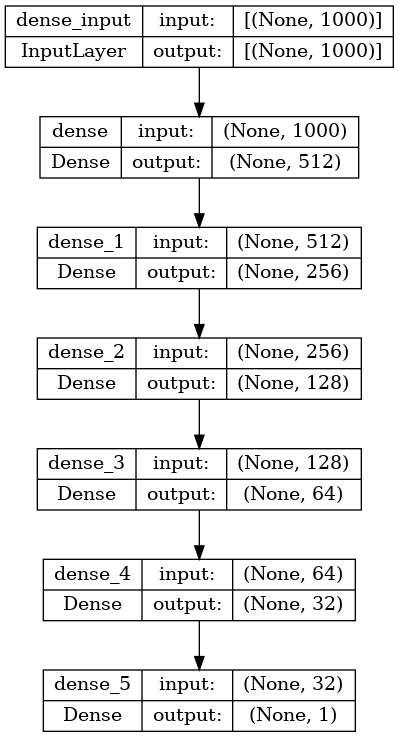

In [5]:
# Plot and save the model structure
model_structure_file = os.path.join(dir_output, 'model_structure.png')
plot_model(model, to_file=model_structure_file, show_shapes=True, show_layer_names=True)
print(f"Model structure saved to: {model_structure_file}")
display(Image(filename=model_structure_file))

## Plot the loss curve of the training process

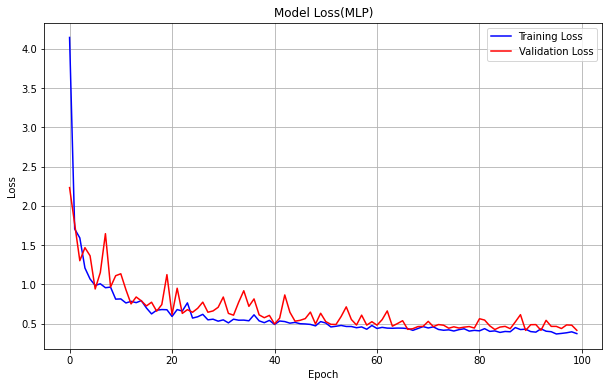

In [6]:
# Plot the loss curve during training
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Model Loss(MLP)')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'training_loss.png'))
plt.show()

# Predict and calculate accuracy

## Model Prediction:
- `y_pred`: Contains the predicted values for the test set generated by the trained model.
- The predicted values are compared with the true values (`y_test`) to evaluate the model's performance.

## Performance Evaluation:
- **Mean Squared Error (MSE)**: This metric calculates the average squared difference between predicted and actual values. A lower value indicates a better fit.
- **R² Score**: This metric represents the proportion of the variance in the dependent variable that is predictable from the independent variables. A value closer to 1 indicates a better model fit.

# Save Predictions:
- The predicted values (`y_pred`) are saved into a CSV file for future reference or further analysis.
- Example: `'predictions.csv'` (file where predictions are stored).

## Visualization:
- A plot is generated to compare the true and predicted values visually, providing insights into the model's performance.
- The plot is saved as `'true_vs_predicted.png'` for easy access.

16/16 [==============================] - 0s 2ms/step


Test MSE: 0.332462
Test R² Score: 0.959405


Test MSE: 0.332462
Test R² Score: 0.959405


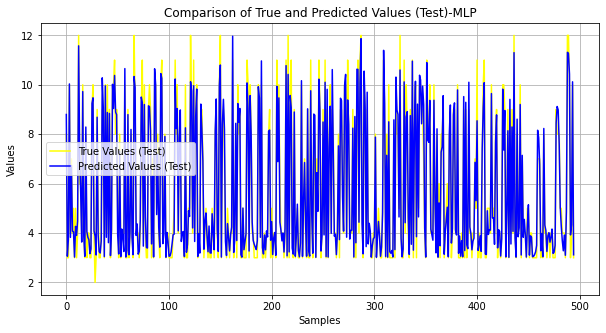

In [7]:
# Predict and calculate accuracy
y_pred = model.predict(X_test).flatten()

# Calculate and print Mean Squared Error (MSE) and R² score
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Test MSE: {mse:.6f}")
print(f"Test R² Score: {r2:.6f}")
logging.info(f"Test MSE: {mse:.6f}")
logging.info(f"Test R² Score: {r2:.6f}")

# Save predictions
predictions_file = os.path.join(dir_output, 'predictions.csv')
np.savetxt(predictions_file, y_pred, delimiter=',')

# Plot the comparison of predicted and true values
plt.figure(figsize=(10, 5))
plt.plot(y_test, label='True Values (Test)', color='yellow', linewidth=1.5)
plt.plot(y_pred, label='Predicted Values (Test)', color='blue', linewidth=1.5)
plt.xlabel('Samples')
plt.ylabel('Values')
plt.title('Comparison of True and Predicted Values (Test)-MLP')
plt.legend()
plt.grid(True)
plt.savefig(os.path.join(dir_output, 'true_vs_predicted.png'))
plt.show()

